<a href="https://colab.research.google.com/github/alvaro-alencar/TSP_Colapsador_Esmeralda_lote/blob/main/TSP_SOLVER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q numpy matplotlib pandas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy.spatial.distance import pdist, squareform
from google.colab import files

In [ ]:
uploaded = files.upload()

filename = list(uploaded.keys())[0]
print(f"Arquivo carregado: {filename}")

Saving berlin52.tsp to berlin52.tsp
Arquivo carregado: berlin52.tsp


In [ ]:
def read_tsp_file(filepath):
    with open(filepath, "r") as f:
        lines = f.read().splitlines()

    start = lines.index("NODE_COORD_SECTION") + 1
    coords = []
    for line in lines[start:]:
        if line.strip().startswith("EOF") or not line.strip():
            break
        parts = line.strip().split()
        city_id = int(parts[0])
        x, y = float(parts[1]), float(parts[2])
        coords.append((city_id, x, y))

    df = pd.DataFrame(coords, columns=["City", "X", "Y"]).set_index("City")
    return df

cities_df = read_tsp_file(filename)
coords = cities_df[["X", "Y"]].values

In [ ]:
def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

def emerald_perfect_refined_value(n, A=0.003, s=0.1, N=3, phi=np.pi * (3 - np.sqrt(5))):
    E_primal = A * np.sin((2 * np.pi * n) / phi)
    E_primordial = sum([A * np.sin((2 * np.pi * k * n) / phi**k) for k in range(1, N+1)])
    Rn = np.log(n)
    smooth = 1 + s * np.sin((2 * np.pi * n) / (phi * s))
    return (E_primal + E_primordial) * Rn * (n / np.log(n + 1)) * smooth

def compute_city_happiness(coords):
    n = len(coords)
    center = coords.mean(axis=0)
    mean_dists = np.array([np.mean([euclidean_distance(coords[i], coords[j]) for j in range(n) if j != i]) for i in range(n)])
    center_dists = np.array([euclidean_distance(coords[i], center) for i in range(n)])
    norm_mean = 1 - (mean_dists - mean_dists.min()) / (mean_dists.max() - mean_dists.min())
    norm_center = 1 - (center_dists - center_dists.min()) / (center_dists.max() - center_dists.min())
    happiness = 0.5 * norm_mean + 0.5 * norm_center
    return happiness

def total_cost(route, coords):
    return sum(euclidean_distance(coords[route[i]], coords[route[i+1]]) for i in range(len(route)-1)) + euclidean_distance(coords[route[-1]], coords[route[0]])

def two_opt(route, coords):
    best = route[:]
    improved = True
    while improved:
        improved = False
        for i in range(1, len(route) - 2):
            for j in range(i + 1, len(route)):
                new_route = best[:i] + best[i:j+1][::-1] + best[j+1:]
                if total_cost(new_route, coords) < total_cost(best, coords):
                    best = new_route
                    improved = True
        route = best[:]
    return best

def solve_affective_harmonic_tsp(coords):
    n = len(coords)
    happiness = compute_city_happiness(coords)
    harmony_raw = np.array([emerald_perfect_refined_value(i+1) for i in range(n)])
    harmony_norm = (harmony_raw - harmony_raw.min()) / (harmony_raw.max() - harmony_raw.min())
    ifc_plus = 0.5 * happiness + 0.5 * harmony_norm
    sorted_indices = np.argsort(-ifc_plus)
    refined_route = two_opt(sorted_indices.tolist(), coords)
    return refined_route, ifc_plus

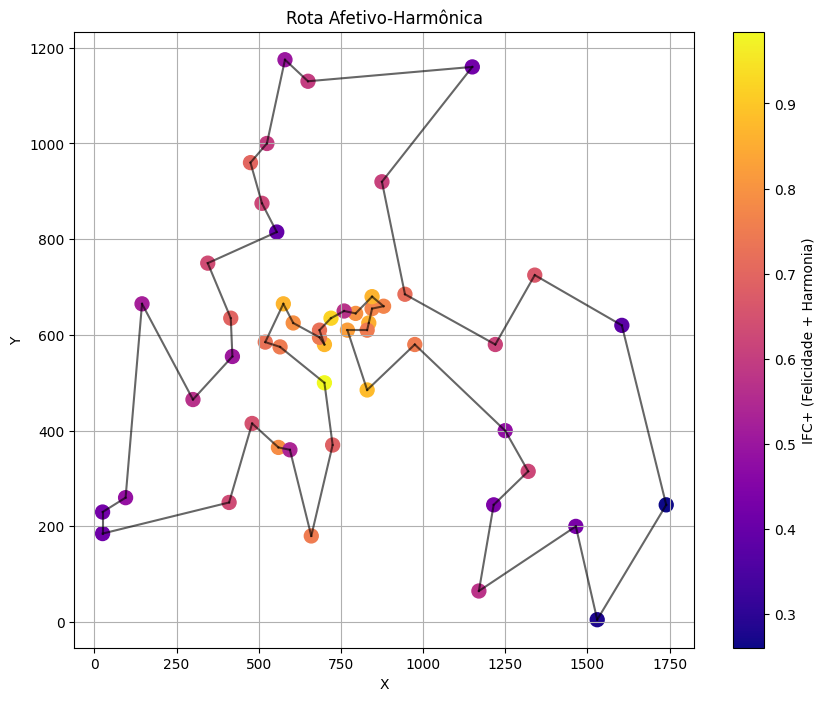

Custo Total da Rota: 8130.15
Tempo de Execução: 2.625 segundos


In [ ]:

start_time = time.time()

final_route, ifc_plus = solve_affective_harmonic_tsp(coords)

exec_time = time.time() - start_time
final_cost = total_cost(final_route, coords)

plt.figure(figsize=(10, 8))
for i in range(len(final_route)):
    start = coords[final_route[i]]
    end = coords[final_route[(i + 1) % len(final_route)]]
    plt.plot([start[0], end[0]], [start[1], end[1]], 'k-', alpha=0.6)

plt.scatter(coords[:, 0], coords[:, 1], c=ifc_plus, cmap='plasma', s=100)
plt.colorbar(label='IFC+ (Felicidade + Harmonia)')
plt.title("Rota Afetivo-Harmônica")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()

print(f"Custo Total da Rota: {final_cost:.2f}")
print(f"Tempo de Execução: {exec_time:.3f} segundos")